In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR
from childes_mi.utils.general import flatten,save_fig

In [3]:
from childes_mi.information_theory import model_fitting as mf

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
MI_DF = pd.read_pickle(DATA_DIR/'mi/drosophila_mi_1000.pickle')

In [7]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,exp_results,pow_results,concat_results,R2_exp,R2_concat,R2_power,AICc_exp,AICc_concat,AICc_power,bestfitmodel,curvature,min_peak
0,"[11.491092426440758, 11.113848299482346, 10.94...","[0.0032096905199801226, 0.0031487970998960533,...","[10.162464643140364, 10.161342744045395, 10.16...","[0.0030504540127070092, 0.00305061298348205, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
MI_DF = MI_DF.assign(**{i:np.nan for i in ['exp_results', 'pow_results', 'concat_results',
     'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
     'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak']})
MI_DF['curvature'] = MI_DF['curvature'].astype(object)

In [9]:
n = 100 # max distance for computation
for idx, row in tqdm(MI_DF.iterrows(), total=len(MI_DF)):
    # get signal
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    sig = sig
    
    # fit models
    results_power, results_exp, results_pow_exp, best_fit_model = mf.fit_models(distances, sig)
    
    # get fit results
    R2_exp, R2_concat, R2_power, AICc_exp, \
        AICc_pow, AICc_concat = mf.fit_results(sig, distances, 
                                              results_exp, results_power,
                                              results_pow_exp)
    
    
    
    
    # get model y
    distances_mod = np.logspace(0,np.log10(n), base=10, num=1000)
    if best_fit_model == 'pow_exp':
        y_model = mf.get_y(mf.pow_exp_decay, results_pow_exp, distances_mod)
    elif best_fit_model == 'exp':
        y_model = mf.get_y(mf.exp_decay, results_exp, distances_mod)
    elif best_fit_model == 'pow':
        y_model = mf.get_y(mf.powerlaw_decay, results_power, distances_mod)
    
    # get curvature of model_y
    curvature_model = mf.curvature(np.log(y_model))
    
    # if the best fit model is pow_exp, then grab the min peak
    if best_fit_model == 'pow_exp':
        # get peaks of curvature
        peaks = np.where((
            (curvature_model[:-1] < curvature_model[1:])[1:] & (curvature_model[1:] < curvature_model[:-1])[:-1]
        ))
        min_peak = peaks[0][0]
    else:
        min_peak = np.nan

    # get save model fit results to MI_DF
    MI_DF.loc[idx, np.array(['exp_results', 'pow_results', 'concat_results',
                         'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
                         'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak'])] = [
        results_exp, results_power, results_pow_exp,
        R2_exp, R2_concat, R2_power, AICc_exp,
        AICc_concat, AICc_pow, best_fit_model,
        curvature_model, min_peak
    ]


In [10]:
MI_DF

,MI,MI_var,shuff_MI,shuff_MI_var,distances,exp_results,pow_results,concat_results,R2_exp,R2_concat,R2_power,AICc_exp,AICc_concat,AICc_power,bestfitmodel,curvature,min_peak
0,"[11.491092426440758, 11.113848299482346, 10.94...","[0.0032096905199801226, 0.0031487970998960533,...","[10.162464643140364, 10.161342744045395, 10.16...","[0.0030504540127070092, 0.00305061298348205, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.952085,0.999521,0.995571,-6513.666172,-11115.26092,-8894.92732,pow_exp,"[3.129027579848531e-07, 4.695250164558214e-07,...",881.0


Text(0.5, 1.0, 'Drosophila')

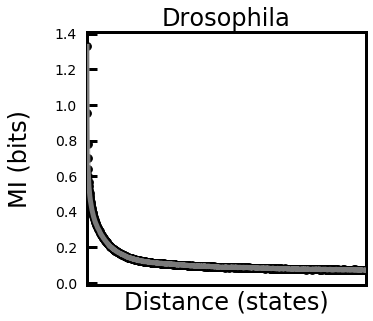

In [34]:
yoff=-.20
ncols = 4
zoom = 5
hr = [1, 0.5, 0.5, 0.5]
nrows = np.ceil(len(MI_DF)/ncols).astype(int)
fig = plt.figure(figsize=(len(MI_DF)*zoom*1.0,np.sum(hr)*zoom)) 
gs = gridspec.GridSpec(ncols=len(MI_DF), nrows=4, height_ratios=hr) 

axi = 0
row = MI_DF.iloc[0]

color = 'k'#LCOL_DICT[row.language]
ax0 = plt.subplot(gs[0,axi])
ax = ax0
sig = np.array(row.MI-row.shuff_MI)
distances = row.distances
sig = sig
# get signal limits
sig_lims = np.log([np.min(sig[sig>0]), np.nanmax(sig)])
sig_lims = [sig_lims[0] - (sig_lims[1]-sig_lims[0])/10,
                sig_lims[1] + (sig_lims[1]-sig_lims[0])/10]

# plot real data
ax.scatter(distances, sig, alpha = 1, s=60, color=color)   

# plot modelled data
#ax.plot(distances, y_model, alpha = 0.25, lw=10, color=color)
ax.plot(distances, sig, alpha = 0.8, lw=5, color="#999999", zorder=10)



ax.set_xlabel('Distance (states)', labelpad=5, fontsize=24)
#print(row.language, distances[peak_of_interest])

ax.set_ylabel('MI (bits)', labelpad=5, fontsize=24)
ax.yaxis.set_label_coords(yoff,0.5)


ax.set_xlim([distances[0], distances[-1]])
sig_lims[0] = np.log(10e-6)
#ax.set_ylim([1e-2, 3])
ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
ax.tick_params(which='major', length=10, width =3)
ax.tick_params(which='minor', length=5, width =2)
#ax.set_xscale( "log" , basex=10)
#ax.set_yscale( "log" , basey=10)
ax.set_xticks([])
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')


if axi !=0:
    for ax in [ax0,ax1,ax2]:
        ax.yaxis.set_ticklabels([])

gs.update(wspace=0.075, hspace=0.1)
ax0.set_title("Drosophila", fontsize=24)
#save_fig(FIGURE_DIR/'drosophila_mi-1000')

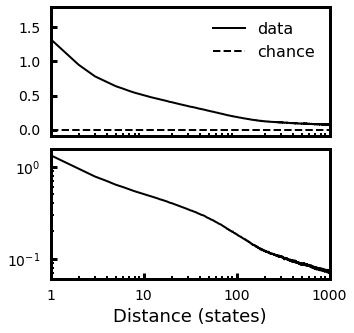

In [85]:
yoff=-.20
ncols = 4
zoom = 5
hr = [1, 1]
nrows = np.ceil(len(MI_DF)/ncols).astype(int)
fig = plt.figure(figsize=(5,5)) 
gs = gridspec.GridSpec(ncols=len(MI_DF), nrows=2, height_ratios=hr) 

ax0 = plt.subplot(gs[0,axi])
ax = ax0
row = MI_DF.iloc[0]

sig = np.array(row.MI-row.shuff_MI)
distances = row.distances
sig = sig
# get signal limits
sig_lims = np.log([np.min(sig[sig>0]), np.nanmax(sig)])
sig_lims = [sig_lims[0] - (sig_lims[1]-sig_lims[0])/10,
                sig_lims[1] + (sig_lims[1]-sig_lims[0])/10]

# plot real data
ax.plot(distances, sig, alpha = 1, lw=2, color="k", zorder=10, label='data')

ax.set_xlabel('Distance (states)', labelpad=5, fontsize=18)
#print(row.language, distances[peak_of_interest])

#ax.set_ylabel('MI rel. chance (bits)', labelpad=5, fontsize=18)
ax.yaxis.set_label_coords(yoff,0.5)


ax.set_xscale( "log" , basex=10)
#ax.set_yscale( "log" , basey=10)


ax.set_xlim([distances[0], distances[-1]])
#sig_lims[0] = np.log(10e-6)

ax.axhline(0, alpha = 1, lw=2, color="k", ls='dashed', zorder=10, label='chance')

ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
ax.tick_params(which='major', length=6, width =3)
ax.tick_params(which='minor', length=3, width =2)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
ax.set_xticks([])
#ax.set_ylim([-0.1, 1.5])

legend= ax.legend(fontsize=16, frameon=False)

gs.update(wspace=0.075, hspace=0.1)
#ax0.set_title("Drosophila", fontsize=24)
#save_fig(FIGURE_DIR/'drosophila_mi-1000')

ax.set_ylim([-0.1, 1.8])




ax0 = plt.subplot(gs[1,axi])
ax = ax0
row = MI_DF.iloc[0]

# plot real data
#ax.scatter(distances, sig, alpha = 1, s=60, color=color)   
ax.plot(distances, sig, alpha = 1, lw=2, color="k", zorder=10, label='data')



ax.set_xlabel('Distance (states)', labelpad=5, fontsize=18)


#ax.set_ylabel('MI rel. chance (bits)', labelpad=5, fontsize=18)
ax.yaxis.set_label_coords(yoff,0.5)


ax.set_xscale( "log" , basex=10)
ax.set_yscale( "log" , basey=10)


ax.set_xlim([distances[0], distances[-1]])
#sig_lims[0] = np.log(10e-6)

ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
ax.tick_params(which='major', length=6, width =3)
ax.tick_params(which='minor', length=3, width =2)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
ax.set_xticks([1,10,100, 1000])
ax.set_xticklabels(['1','10','100', '1000'])
#ax.set_ylim([-0.1, 1.5])

#legend= ax.legend(fontsize=16, frameon=False)

gs.update(wspace=0.075, hspace=0.1)
#ax0.set_title("Drosophila", fontsize=24)
save_fig(FIGURE_DIR/'zf_mi-1000-preview')

In [86]:
FIGURE_DIR

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/childes_mi_project/figures')